In [23]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, norm, f_oneway
import pingouin as pg
from pingouin import kruskal
import scikit_posthocs as sp
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
import seaborn as sns

In [4]:
mgdf = pd.read_excel('CA_SUR.xlsx',sheet_name='Muestreo mgL')

medf = pd.read_excel('CA_SUR.xlsx',sheet_name='Muestreo meqL')

C:\Users\un\AppData\Local\Temp\ipykernel_17036\1733789073.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x='Variable', y='Valor', palette='Set3', showmeans=True)


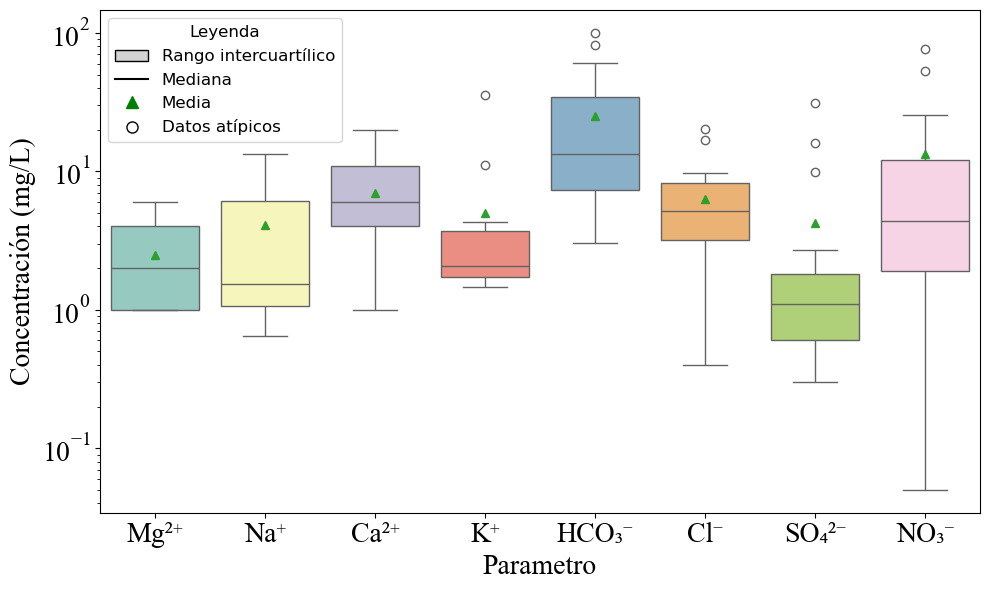

In [6]:
# Filtrar datos según la clase deseada
clase_deseada = 'ZEM VI'
df_fil = mgdf[mgdf['Campo'] == clase_deseada] if clase_deseada else mgdf

# Variables a analizar
iones = ['Mg', 'Na', 'Ca', 'K', 'HCO3', 'Cl', 'SO4', 'NO3']
iones_superindice = {
    'Mg': 'Mg²⁺',
    'Na': 'Na⁺',
    'Ca': 'Ca²⁺',
    'K': 'K⁺',
    'HCO3': 'HCO₃⁻',
    'Cl': 'Cl⁻',
    'SO4': 'SO₄²⁻',
    'NO3': 'NO₃⁻'
}

# Reorganizar el DataFrame
df_melted = df_fil.melt(id_vars=['Marker'], value_vars=iones, var_name='Variable', value_name='Valor')
df_melted['Variable'] = df_melted['Variable'].replace(iones_superindice)

# Crear el boxplot con Matplotlib
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Variable', y='Valor', palette='Set3', showmeans=True)

# Personalizar el gráfico
plt.yscale('log')  # Escala logarítmica
#plt.ylim(bottom=-1)  # Límite inferior en 0
#plt.title('Boxplot de iones mayoritarios ZEM NORTE', fontsize=16, fontfamily='Times New Roman')
plt.xlabel('Parametro', fontsize=20, fontfamily='Times New Roman')
plt.ylabel('Concentración (mg/L)', fontsize=20, fontfamily='Times New Roman')
plt.xticks(fontsize=20, fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontfamily='Times New Roman')


# Crear elementos de leyenda personalizados
legend_elements = [
    Patch(facecolor='lightgray', edgecolor='black', label='Rango intercuartílico'),
    Line2D([0], [0], color='black', label='Mediana', linestyle='-'),
    Line2D([0], [0], color='green', label='Media', marker='^', linestyle='', markersize=8),
    Line2D([0], [0], color='black', marker='o', markerfacecolor='white', label='Datos atípicos', linestyle='', markersize=8),
]

plt.legend(handles=legend_elements, loc='best', fontsize=12, title='Leyenda', title_fontsize=12, frameon=True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [11]:
pg.normality(data = medf, dv = 'NO3', group = 'Clase')

C:\Users\un\anaconda3\Lib\site-packages\pingouin\distribution.py:242: UserWarning: Group Superficicial has less than 4 valid samples. Returning NaN.
  warnings.warn(f"Group {idx} has less than 4 valid samples. Returning NaN.")


,W,pval,normal
Clase,,,
Subterranea,0.459770,6.248880e-16,False
Superficial,0.869333,1.406955e-02,False
Superficicial,NaN,NaN,False


In [13]:
pg.normality(data = medf, dv = 'NO3', group = 'Campo')

,W,pval,normal
Campo,,,
CAMPO II,0.543717,1.039053e-07,False
CAMPO III,0.792944,7.797312e-03,False
ZEM IV,0.317570,1.433193e-09,False
ZEM V,0.404268,1.312267e-07,False
CH23,0.418398,1.047231e-06,False
ZEM VI,0.660653,4.282937e-05,False


In [15]:
pg.normality(data = medf, dv = 'Mg', group = 'Season')

,W,pval,normal
Season,,,
Wet,0.848472,9.367907e-07,False
Dry,0.801943,1.426257e-05,False


In [17]:
pg.normality(data = medf, dv = 'NO3', group = 'Tipo')

C:\Users\un\anaconda3\Lib\site-packages\pingouin\distribution.py:242: UserWarning: Group Cienaga  has less than 4 valid samples. Returning NaN.
  warnings.warn(f"Group {idx} has less than 4 valid samples. Returning NaN.")
C:\Users\un\anaconda3\Lib\site-packages\pingouin\distribution.py:242: UserWarning: Group Rio has less than 4 valid samples. Returning NaN.
  warnings.warn(f"Group {idx} has less than 4 valid samples. Returning NaN.")


,W,pval,normal
Tipo,,,
Pozo,0.628177,1.137282e-09,False
Aljibe,0.639396,1.211095e-07,False
Manantial,0.836830,4.042626e-02,False
ABAS,0.629776,1.240726e-03,False
Cienaga,NaN,NaN,False
Quebrada,0.890738,3.220748e-01,True
Rio,NaN,NaN,False


In [19]:
grupo_col = 'Season'  # Cambia por el nombre real de tu columna de grupos
valor_col = 'Ca'  # Cambia por el nombre real de tu columna de valores

# Agrupar los datos por los grupos y preparar listas para el ANOVA
grupos = medf[grupo_col].unique()
datos_grupos = [medf[medf[grupo_col] == g][valor_col].values for g in grupos]

# Realizar el ANOVA de una vía
anova_resultado = f_oneway(*datos_grupos)

# Mostrar resultados
print("\nResultados del ANOVA:")
print(f"F-statistic: {anova_resultado.statistic}")
print(f"P-value: {anova_resultado.pvalue}")

# Interpretación
alpha = 0.05  # Nivel de significancia
if anova_resultado.pvalue < alpha:
    print("\nEl resultado es significativo: Hay diferencias entre los grupos.")
else:
    print("\nEl resultado no es significativo: No hay diferencias entre los grupos.")


Resultados del ANOVA:
F-statistic: 1.6175256576476509
P-value: 0.20632928879750087

El resultado no es significativo: No hay diferencias entre los grupos.


In [21]:
kruskal(data = medf, dv= 'NO3', between = 'Campo')

,Source,ddof1,H,p-unc
Kruskal,Campo,5,9.806064,0.080921


In [23]:
kruskal(data = medf, dv= 'NO3', between = 'Tipo')

,Source,ddof1,H,p-unc
Kruskal,Tipo,6,40.937747,2.978591e-07


In [25]:
kruskal(data = medf, dv= 'NO3', between = 'Season')

,Source,ddof1,H,p-unc
Kruskal,Season,1,2.444873,0.117909


In [27]:
kruskal(data = medf, dv= 'NO3', between = 'Clase')

,Source,ddof1,H,p-unc
Kruskal,Clase,2,3.566985,0.16805


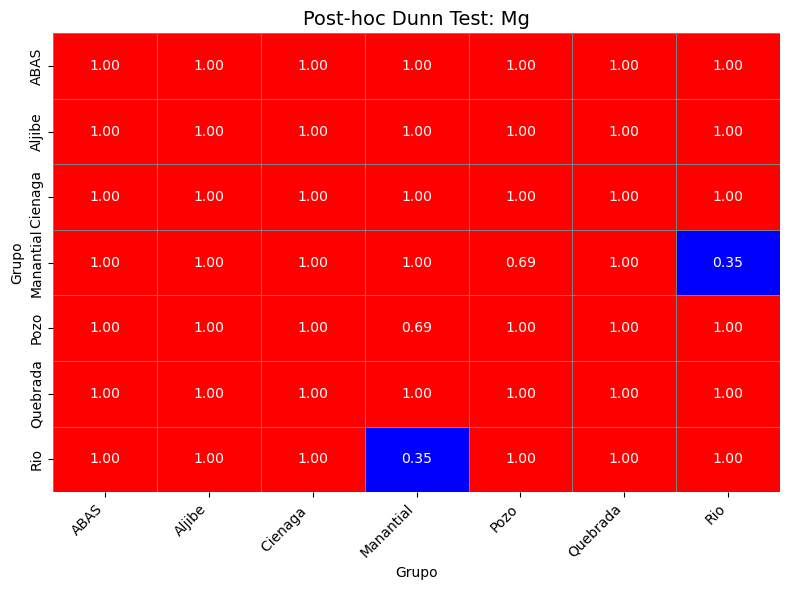

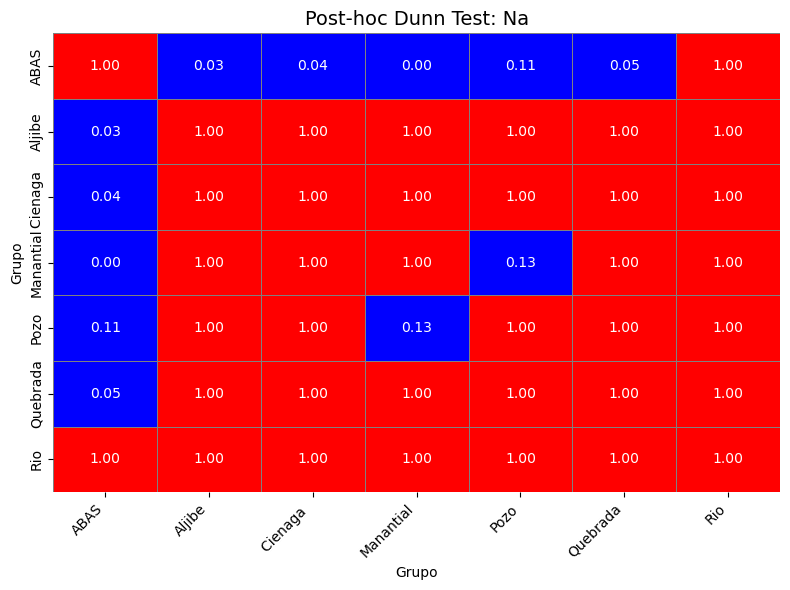

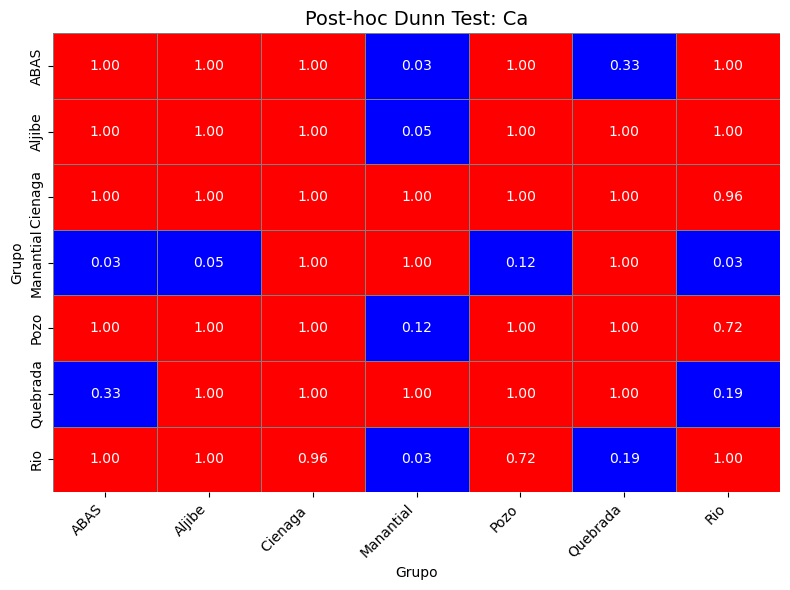

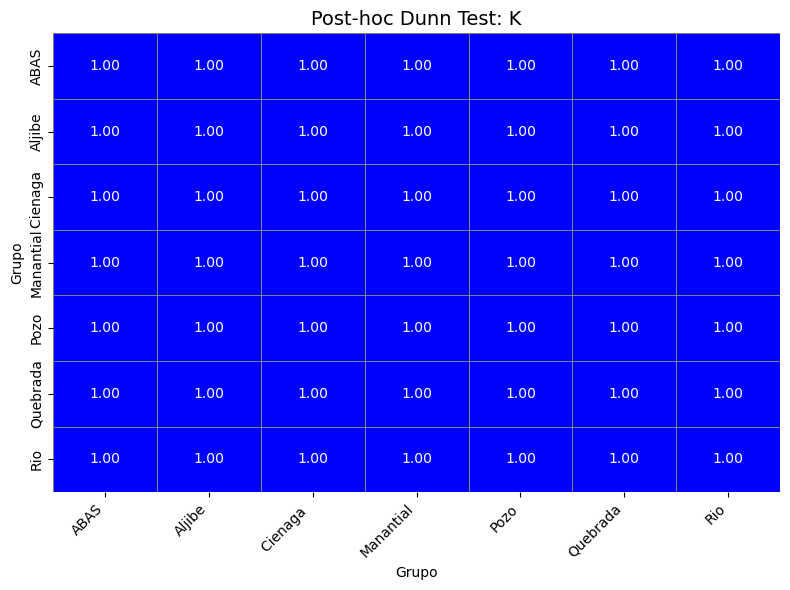

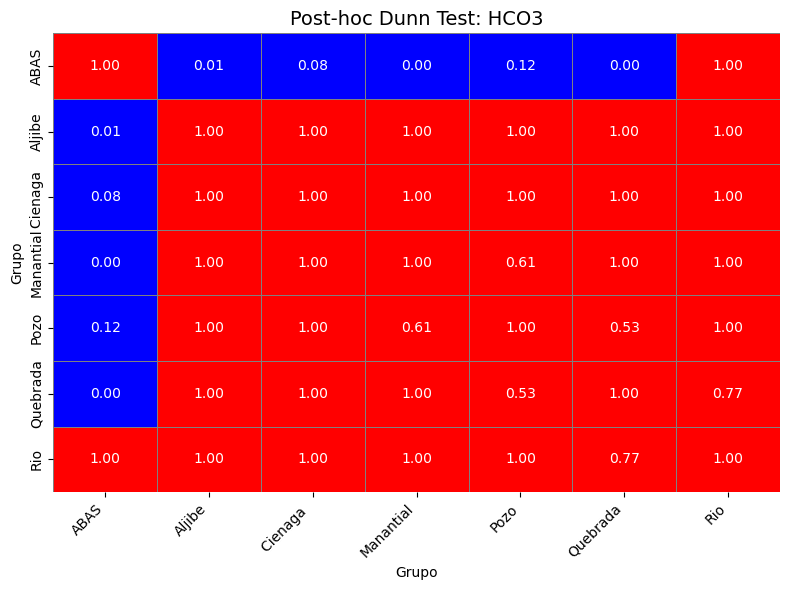

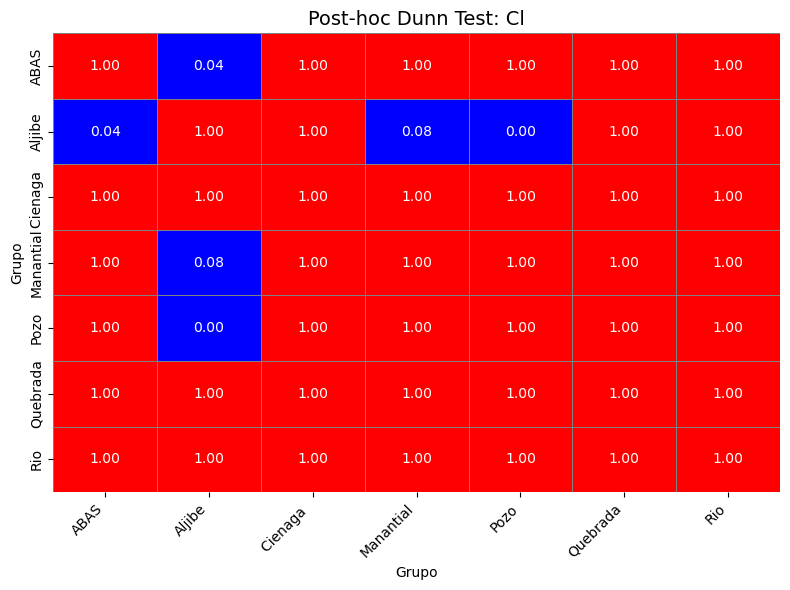

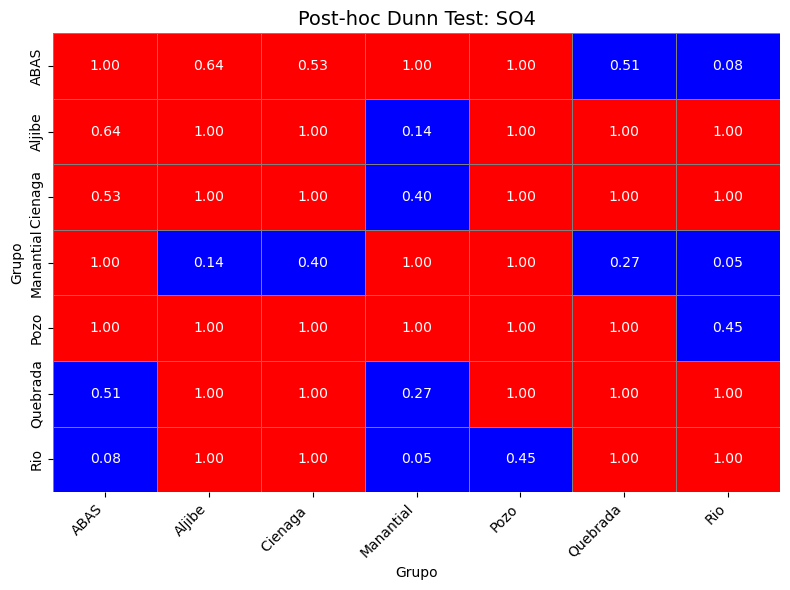

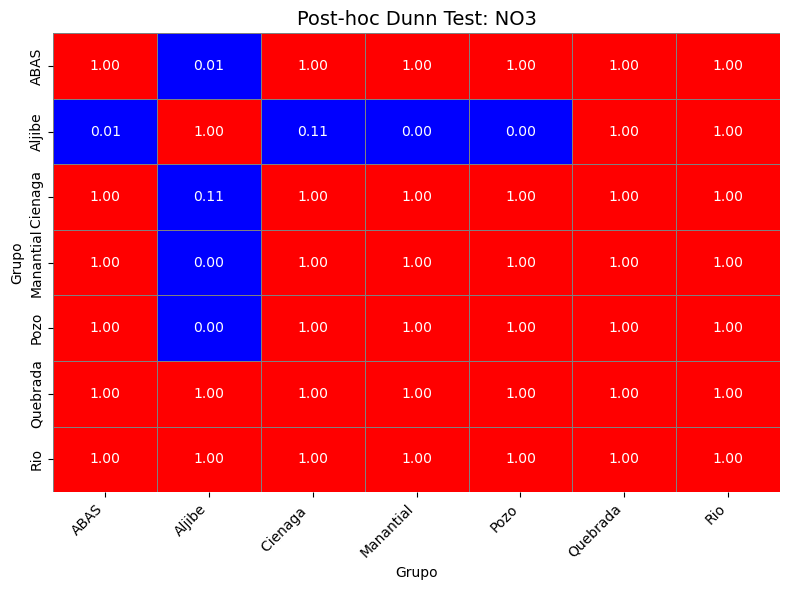

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

# Función para graficar mapas de calor
def plot_posthoc_heatmap(medf, val_col, group_col, title):
    # Realizar la prueba post-hoc de Dunn con ajuste Bonferroni
    posthoc_df = sp.posthoc_dunn(medf, val_col=val_col, group_col=group_col, p_adjust='bonferroni')
    
    # Crear el mapa de calor con diferencias significativas (rojo) y no significativas (azul)
    plt.figure(figsize=(8, 6))
    sns.heatmap(posthoc_df, annot=True, fmt='.2f', cmap=sns.color_palette(["blue", "red"], as_cmap=True),
                linewidths=0.5, linecolor='gray', cbar=False, annot_kws={"size": 10})
    plt.title(title, fontsize=14)
    plt.xlabel('Grupo')
    plt.ylabel('Grupo')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(f'Dunn_{val_col}.jpeg', format='jpeg', dpi=300)

# Generar gráficos para cada DataFrame y variable
try:
    # Primer DataFrame (Mg)
    plot_posthoc_heatmap(medf, val_col='Mg', group_col='Tipo', title='Post-hoc Dunn Test: Mg')
    
    # Segundo DataFrame (Na)
    plot_posthoc_heatmap(medf, val_col='Na', group_col='Tipo', title='Post-hoc Dunn Test: Na')
    
    # Tercer DataFrame (Ca)
    plot_posthoc_heatmap(medf, val_col='Ca', group_col='Tipo', title='Post-hoc Dunn Test: Ca')
    
    # Primer DataFrame (K)
    plot_posthoc_heatmap(medf, val_col='K', group_col='Tipo', title='Post-hoc Dunn Test: K')
    
    # Segundo DataFrame (HCO3)
    plot_posthoc_heatmap(medf, val_col='HCO3', group_col='Tipo', title='Post-hoc Dunn Test: HCO3')
    
    # Tercer DataFrame (Cl)
    plot_posthoc_heatmap(medf, val_col='Cl', group_col='Tipo', title='Post-hoc Dunn Test: Cl')

    # Primer DataFrame (SO4)
    plot_posthoc_heatmap(medf, val_col='SO4', group_col='Tipo', title='Post-hoc Dunn Test: SO4')
    
    # Segundo DataFrame (NO3)
    plot_posthoc_heatmap(medf, val_col='NO3', group_col='Tipo', title='Post-hoc Dunn Test: NO3')
    
except Exception as e:
    print(f"Error generado: {e}. Asegúrate de que los DataFrames y columnas existan.")


In [31]:
def waterclust_python(data, height, typ, output_file="resultados_clustering.csv"):
    """
    Función para realizar clustering jerárquico replicando el código de R.
    :param data: DataFrame con los datos de entrada.
    :param height: Altura para cortar el dendrograma y definir los clústeres.
    :param typ: Tipo de análisis (1 para usar CLR).
    :param output_file: Nombre del archivo CSV para exportar los resultados.
    :return: DataFrame con los clústeres asignados.
    """
    # 1. Eliminar las primeras columnas no relevantes
    datachem = data.iloc[:, 1:].copy()  # Selecciona columnas químicas
    nombres = data['ID'] if 'ID' in data.columns else None

    # Verificar si datachem tiene valores válidos
    if datachem.isnull().any().any():
        raise ValueError("Los datos químicos contienen valores nulos. Imputa o elimina los nulos antes de proceder.")

    # 2. Normalización composicional (análogo a acomp en R)
    datachem_normalized = datachem.div(datachem.sum(axis=1), axis=0)
    
    # 3. Transformación CLR
    def clr_transform(matrix):
        """Aplica la transformación CLR (Centered Log-Ratio)"""
        log_data = np.log(matrix + 1e-10)  # Añade un pequeño valor para evitar log(0)
        geom_mean = np.mean(log_data, axis=1, keepdims=True)
        return log_data - geom_mean

    if typ == 1:
        datachem_clr = clr_transform(datachem_normalized.values)
        dist_matrix = pdist(datachem_clr)  # Calcula la matriz de distancias entre filas
    else:
        datachem_clr = datachem_normalized.values
        dist_matrix = pdist(datachem_clr)

    # 4. Generar el dendrograma
    linkage_matrix = linkage(dist_matrix, method='ward')  # Método Ward para clustering

    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, labels=nombres.values if nombres is not None else None, color_threshold=height)
    plt.title('Dendrograma')
    plt.xlabel('Muestras')
    plt.ylabel('Distancia')
    plt.axhline(y=height, color='r', linestyle='--')  # Línea de corte
    plt.show()

    # 5. Cortar el dendrograma para obtener clústeres
    clusters = fcluster(linkage_matrix, t=height, criterion='distance')  # Define clústeres según altura

    # 6. Asegurar que el número de clústeres coincida con las filas del DataFrame original
    if len(clusters) != len(data):
        raise ValueError(
            f"Número de clústeres ({len(clusters)}) no coincide con el número de filas en los datos ({len(data)})."
        )

    # 7. Añadir los clústeres al DataFrame original
    data['Cluster'] = clusters

    # 8. Imprimir los resultados
    #print(data)

    # 9. Exportar los resultados a un archivo CSV
    data.to_csv(output_file, index=False, encoding='utf-8')
    print(f"Datos exportados exitosamente a {output_file}")

     
    return [data, datachem] 

In [36]:
medf = pd.read_excel('Balance_S.xlsx',sheet_name='Balance_S')

medf1 = medf[['ID', 'HCO3', 'Ca', 'Mg', 'Fe', 'Mn', 'K', 'Na', 'NO3', 'Cl', 'SO4', 'PO4']]

medf2 = medf1.dropna()

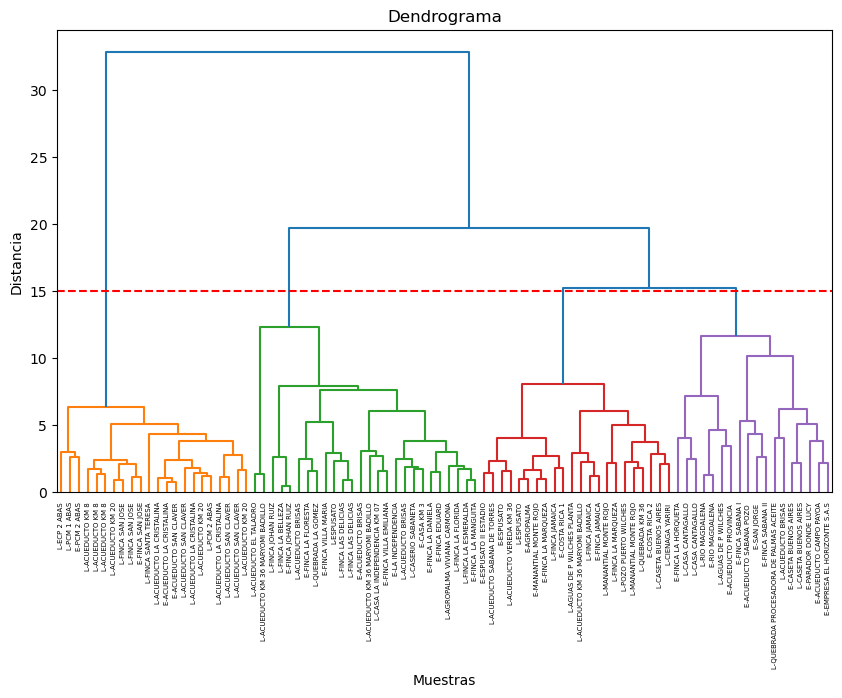

Datos exportados exitosamente a clusters_finales.csv


In [40]:
result = waterclust_python(medf2, height=15, typ=1, output_file="clusters_finales.csv")

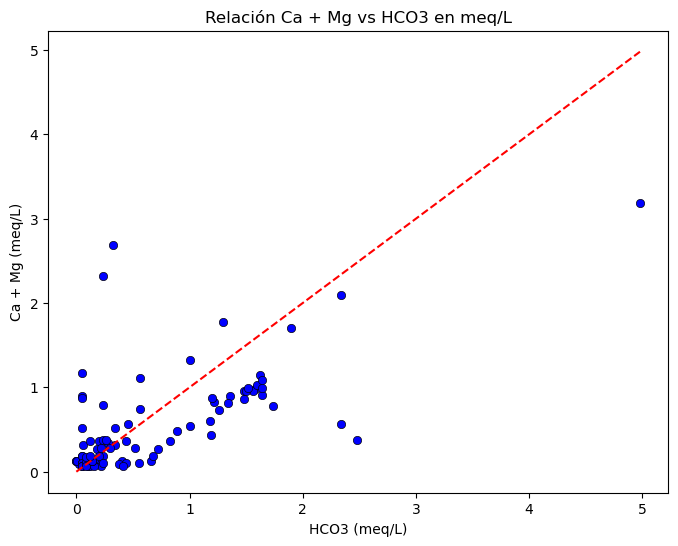

In [75]:
# Sumar las concentraciones de Ca y Mg
medf["Ca_Mg_meq"] = medf["Ca"] + medf["Mg"]

# Definir rango para la línea 1:1
min_val = min(medf["Ca_Mg_meq"].min(), medf["HCO3"].min())  # Valor mínimo del eje
max_val = max(medf["Ca_Mg_meq"].max(), medf["HCO3"].max())  # Valor máximo del eje

# Crear gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(y=medf["Ca_Mg_meq"], x=medf["HCO3"], color='b', edgecolor='black')

# Agregar la línea de relación 1:1
plt.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--', label="Relación 1:1")

# Etiquetas
plt.ylabel("Ca + Mg (meq/L)")
plt.xlabel("HCO3 (meq/L)")
plt.title("Relación Ca + Mg vs HCO3 en meq/L")

# Mostrar gráfico
plt.show()

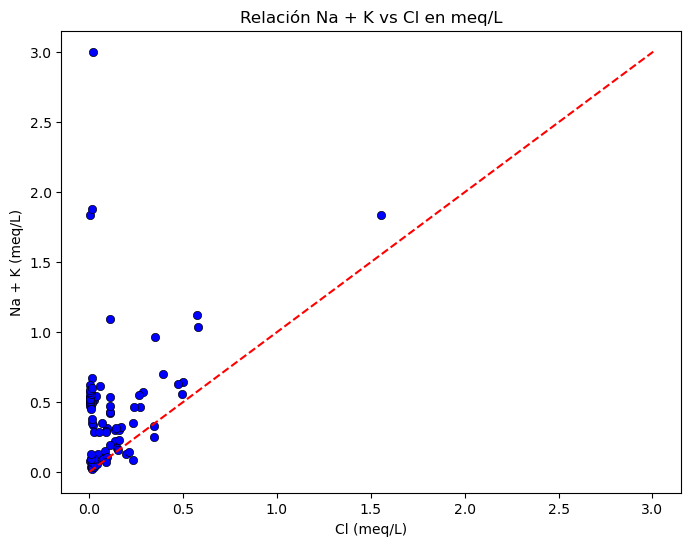

In [77]:
# Sumar las concentraciones de Na y K
medf["Na_K_meq"] = medf["Na"] + medf["K"]

# Definir rango para la línea 1:1
min_val = min(medf["Na_K_meq"].min(), medf["Cl"].min())  # Valor mínimo del eje
max_val = max(medf["Na_K_meq"].max(), medf["Cl"].max())  # Valor máximo del eje

# Crear gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(y=medf["Na_K_meq"], x=medf["Cl"], color='b', edgecolor='black')

# Agregar la línea de relación 1:1
plt.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--', label="Relación 1:1")

# Etiquetas
plt.ylabel("Na + K (meq/L)")
plt.xlabel("Cl (meq/L)")
plt.title("Relación Na + K vs Cl en meq/L")

# Mostrar gráfico
plt.show()

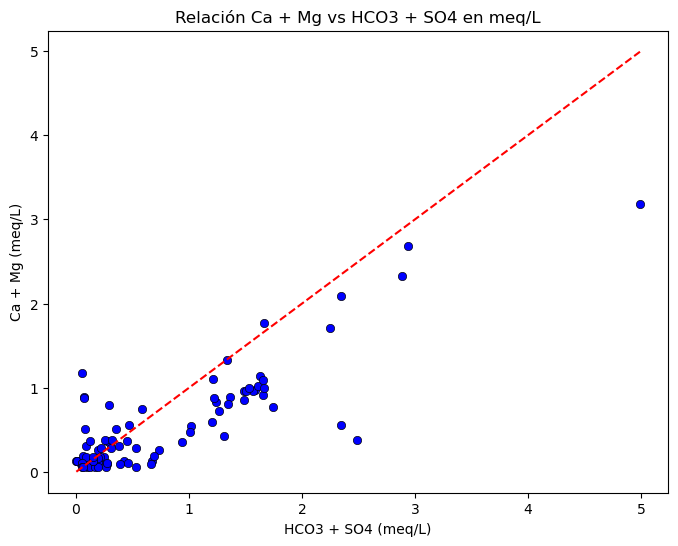

In [79]:
# Sumar las concentraciones de Ca y Mg
medf["Ca_Mg_meq"] = medf["Ca"] + medf["Mg"]

# Sumar las concentraciones de HCO3 y SO4
medf["HCO3_SO4_meq"] = medf["HCO3"] + medf["SO4"]

# Definir rango para la línea 1:1
min_val = min(medf["Ca_Mg_meq"].min(), medf["HCO3_SO4_meq"].min())  # Valor mínimo del eje
max_val = max(medf["Ca_Mg_meq"].max(), medf["HCO3_SO4_meq"].max())  # Valor máximo del eje

# Crear gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(y=medf["Ca_Mg_meq"], x=medf["HCO3_SO4_meq"], color='b', edgecolor='black')

# Agregar la línea de relación 1:1
plt.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--', label="Relación 1:1")

# Etiquetas
plt.ylabel("Ca + Mg (meq/L)")
plt.xlabel("HCO3 + SO4 (meq/L)")
plt.title("Relación Ca + Mg vs HCO3 + SO4 en meq/L")

# Mostrar gráfico
plt.show()

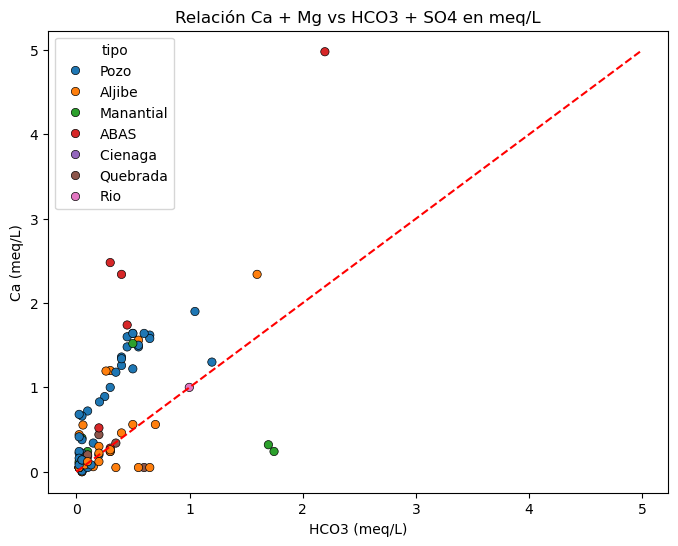

In [73]:
# Sumar las concentraciones de Ca y Mg
#medf["Ca_Mg_meq"] = medf["Ca"] + medf["Mg"]

# Sumar las concentraciones de HCO3 y SO4
#medf["HCO3_SO4_meq"] = medf["HCO3"] + medf["SO4"]

# Definir rango para la línea 1:1
min_val = min(medf["Ca"].min(), medf["HCO3"].min())  # Valor mínimo del eje
max_val = max(medf["Ca"].max(), medf["HCO3"].max())  # Valor máximo del eje

# Crear gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=medf["Ca"], y=medf["HCO3"], hue=medf["tipo"], edgecolor='black')

# Agregar la línea de relación 1:1
plt.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--', label="Relación 1:1")

# Etiquetas
plt.ylabel("Ca (meq/L)")
plt.xlabel("HCO3 (meq/L)")
plt.title("Relación Ca + Mg vs HCO3 + SO4 en meq/L")

# Mostrar gráfico
plt.show()